---

# **Machine Learning Coursework 1**

---

For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

The purpose of this coursework is to help you:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- don't use libraries that implement kNN or cross-validation.  We want to see your code!
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: https://numpydoc.readthedocs.io/en/latest/format.html)
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking 

The grades in this coursework are allocated approximately as follows:

|                                                    | mark  |  
|----------------------------------------------------|-------|
| Data exploration (+ 2 questions)                   | 9     |  
| Code, docu. & comments (KNN + Evaluation + NCV)    | 12    |  
| Results (KNN folds + Summary + Confusion matrices) | 9     |  
| Final questions:                                   | 9     |  
| Overall quality & use of Markdown                  | 6     |  
| Total available                                    |**45** |  


In [1]:
import seaborn as sns
import math

<hr>

## 1. Exploratory Data Analysis [9 pts]

In this coursework we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with. 

In [2]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand.  When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

The following image shows what such a visualisation might look like on the Iris dataset that you worked on during the Topic exercises. 

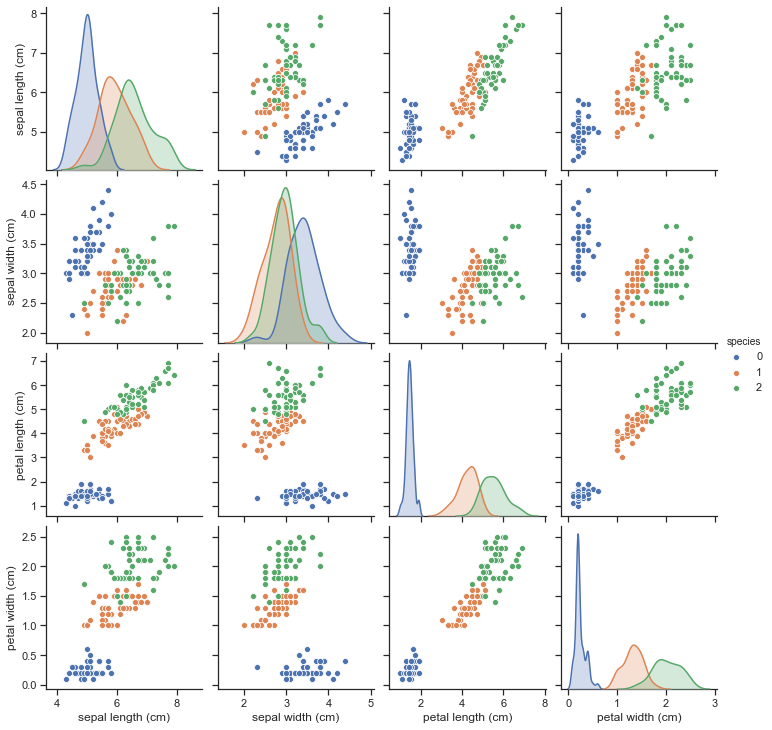

Your first task is to recreate a similar grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a distribution (or histogram) for that feature.     

You should create a function that, given data X and labels y, plots this grid.  The function should be invoked something like this:
        
    myplotGrid(X,y,...)
    
where X is your training data and y are the labels (you may also supply additional optional arguments). You can use an appropriate library to help you create the visualisation. You might want to code it yourself using matplotlib functions scatter and hist - however, this is not strictly necessary here, so try not spend too much time on this. 


<p><b style="color:red">!!!!!</b><b> TO DO: Add documentation for the function </b><b style="color:red">!!!!!</b></p>

In [3]:
# define plotting function
def myplotGrid(x_data, y_data, columns = [], class_name = 'class'):
    df = pd.DataFrame(x_data)
    
    if len(columns) > 0:
        df.columns = columns
        
    df[class_name] = y_data
    sns.set_theme(style="ticks")
    sns.pairplot(
        df,
        hue=class_name,
        palette=sns.color_palette()[:3]
        )

c:\Projects\UoL\(DSM040-2023-APR) Machine learning\DSM040_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


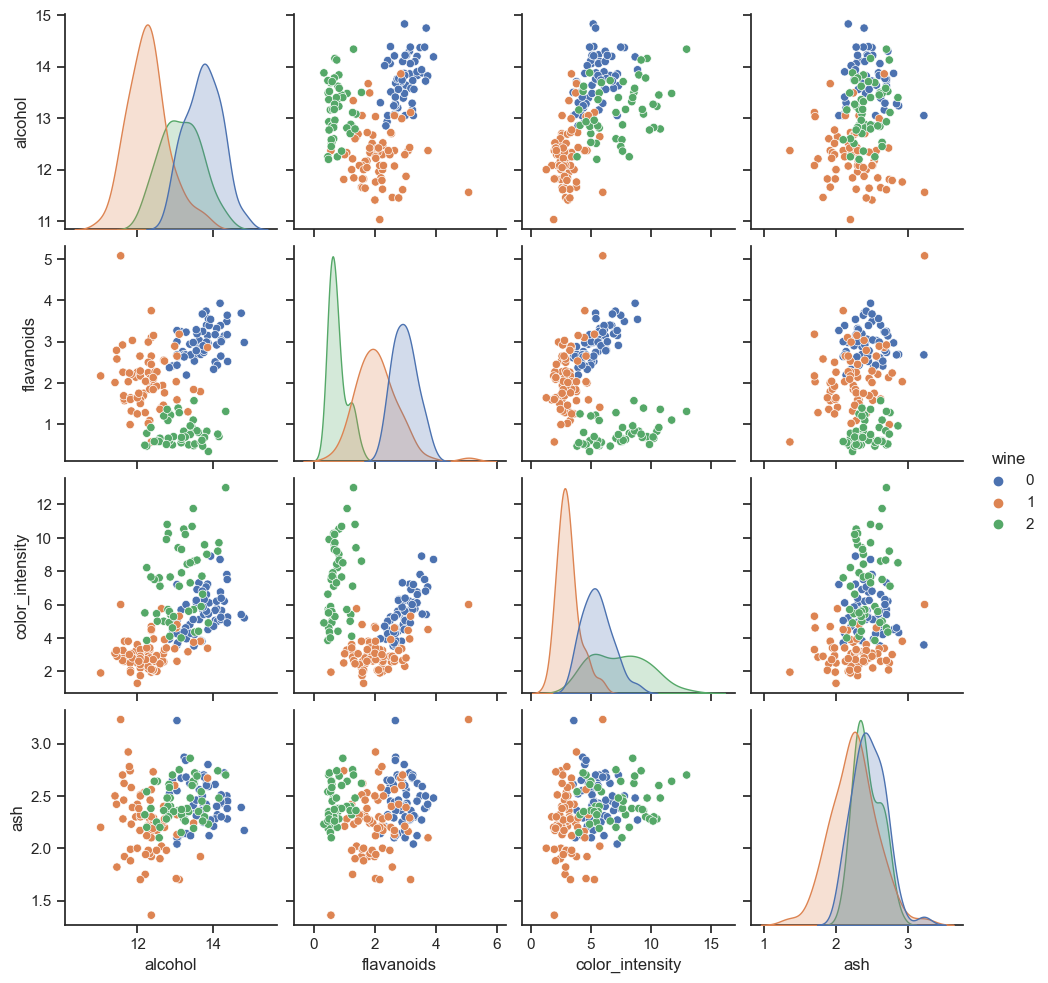

In [4]:
# run the plotting function
myplotGrid(X,y,selected_features,'wine')

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345 
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

c:\Projects\UoL\(DSM040-2023-APR) Machine learning\DSM040_CW1\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


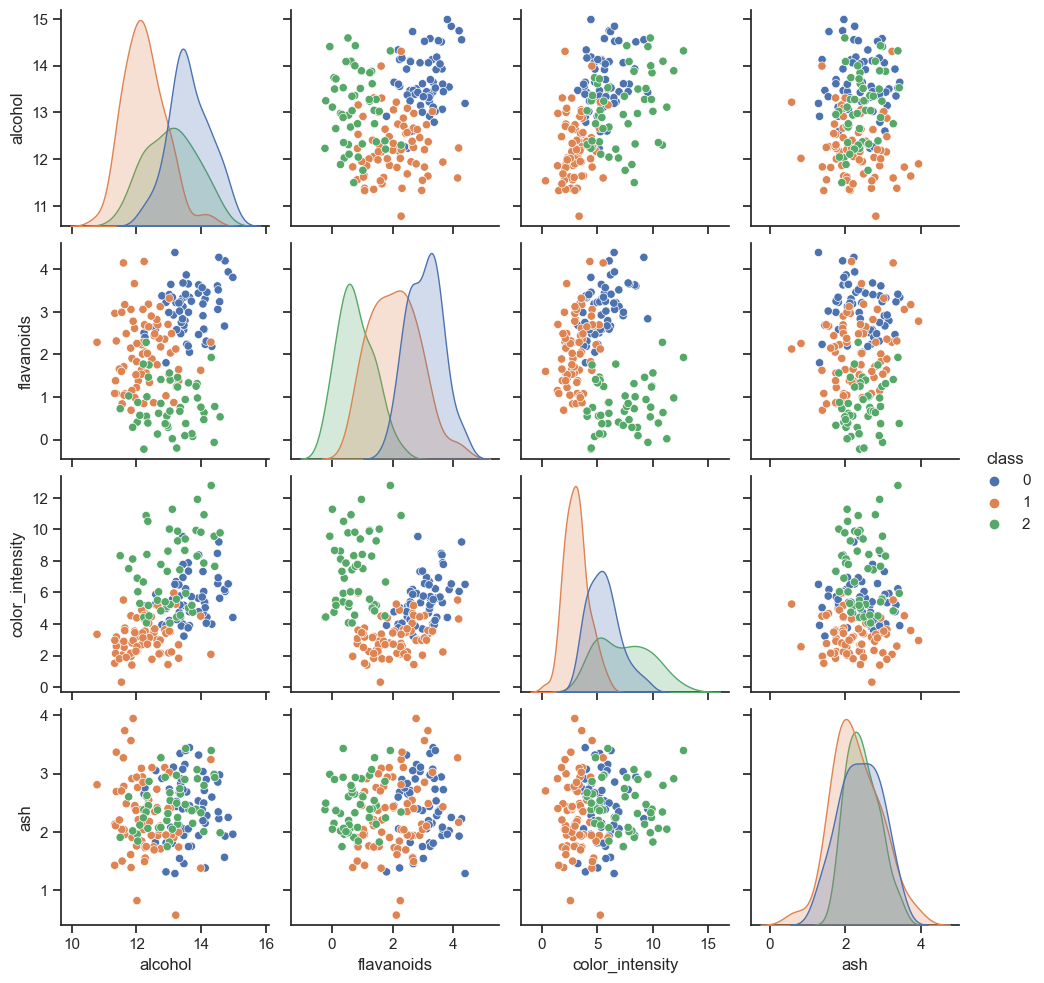

In [5]:
# noise code 
mySeed = 12345 
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y,selected_features)


### Q1. Exploratory data analysis
Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why?  Answer as fully as you can. 


answer:
Color Intensity and Flavanoids both differentiates the classes well, by both having large, non-overlapping sections.
Visually their combined plots also seems to have less overlapping sections than other combinations, meaning that it would be easier to build a classifier with a higher accuracy.


### Q2. Data with noise
What do you observe by plotting the data without noise compared to plotting with added Gaussian noise? 


answer:
Plotting without noise tend to have the clusters per class grouped closer together.
While adding noise spreads the clusters out more and creates a larger overlap between classes.


<hr>

## 2. Implementing kNN [6 pts]

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You may use the scikit-learn k-NN implementation from the labs as a guide - and as a way of verifying your results - but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions. 

Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector. 


(<i>1.6. Nearest Neighbors</i>)

(Burkov, 2019)

In [6]:
# helper code
def abs(value: float):
    return (value ** 2) ** (1/2)

In [7]:
#[1]
def euclidean_distance(row1, row2):
    """
    Calculate the Euclidean distance between two rows of data.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Euclidean distance between the two rows.
    """
    
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return distance**(1/2)

def cosine_distance(row1, row2):
    """
    Calculate the cosine distance between two rows of data.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Cosine distance between the two rows.
    """
    
    xx, xy, yy = 0, 0, 0
    for i in range(len(row1)):
        x = row1[i]; y = row2[i]
        xx += x**2
        yy += y**2
        xy += x*y
    
    #inverted similarity to get distance
    return 1/((xy/(xx**(1/2)))/(yy**(1/2)))

#(Manhattan Distance - an overview | ScienceDirect Topics)
def manhattan_distance(row1, row2):
    """
    Calculate the Manhattan distance between two rows of data.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Manhattan distance between the two rows.
    """
    
    distance = 0.0
    for i in range(len(row1)-1):
        distance += abs(row1[i] - row2[i])
    return distance

def minkowski_distance1(row1, row2):
    """
    Calculate the Minkowski distance (order 1) between two rows of data.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Minkowski distance (order 1) between the two rows.
        9
    """
    distance = 0.0
    for i in range(len(row1)):
        distance += abs(row1[i] - row2[i])
    
    distance = distance
    return distance

def minkowski_distance2(row1, row2):
    """
    Calculate the Minkowski distance (order 2) between two rows of data.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Minkowski distance (order 2) between the two rows.
    """
    
    distance = 0.0
    for i in range(len(row1)):
        distance += abs(row1[i] - row2[i]) ** 2
    
    distance = distance ** (1/2)
    return distance

def minkowski_distance3(row1, row2):
    """
    Calculate the Minkowski distance (order 3) between two rows of data.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Minkowski distance (order 3) between the two rows.
    """
    
    distance = 0.0
    for i in range(len(row1)):
        distance += abs(row1[i] - row2[i]) ** 3
    
    distance = distance ** (1/3)
    return distance

def combined_distance(row1, row2):
    """
    Calculate the combined distance between two rows of data using multiple distance measures.

    Args:
        row1 (array-like): First row of data.
        row2 (array-like): Second row of data.

    Returns:
        distance (float): Combined distance between the two rows.
    """
    
    euclidean = euclidean_distance(row1, row2)
    cosine = cosine_distance(row1, row2)
    manhattan = manhattan_distance(row1, row2)
    minkowski1 = minkowski_distance1(row1, row2)
    minkowski2 = minkowski_distance2(row1, row2)
    minkowski3 = minkowski_distance3(row1, row2)
    
    distance = euclidean + cosine + manhattan + minkowski1 + minkowski2 + minkowski3
    
    return distance

def get_neighbors(train, test_row, k, distance_function):
    """
    Get the indices of the k nearest neighbors for a test row using a specified distance function.

    Args:
        train (list): Training data.
        test_row (array-like): Test row for which to find nearest neighbors.
        k (int): Number of neighbors to retrieve.
        distance_function (str): Distance function to use for calculating distances.
            Available options: 'euclidean', 'cosine', 'manhattan', 'minkowski1', 'minkowski2', 'minkowski3', 'combined'

    Returns:
        neighbors (list): Indices of the k nearest neighbors.
    """
    
    match distance_function:
        case 'euclidean':
            calculate_distance = euclidean_distance
        case 'cosine':
            calculate_distance = cosine_distance
        case 'manhattan':
            calculate_distance = manhattan_distance
        case 'minkowski1':
            calculate_distance = minkowski_distance1
        case 'minkowski2':
            calculate_distance = minkowski_distance2
        case 'minkowski3':
            calculate_distance = minkowski_distance3
        case 'combined':
            calculate_distance = combined_distance
    
    distances = []
    for index, train_row in enumerate(train):
        dist = calculate_distance(test_row, train_row)
        distances.append((train_row, dist, index))
    
    distances.sort(key = lambda tup: tup[1])
    
    return [distances[i][2] for i in range(k)]

In [8]:
# mykNN code
def mykNN(X_train, y_train, test_row, k = 1, distance_function = "euclidean"):
    """
    Perform k-nearest neighbors classification on a test row using a training dataset.

    Args:
        X_train (list): Training data features.
        y_train (list): Training data labels.
        test_row (array-like): Test row for classification.
        k (int, optional): Number of neighbors to consider. Defaults to 1.
        distance_function (str, optional): Distance function to use for calculating distances.
            Available options: 'euclidean', 'cosine', 'manhattan', 'minkowski1', 'minkowski2', 'minkowski3', 'combined'.
            Defaults to 'euclidean'.

    Returns:
        predicted_label: Predicted label for the test row.
    """
    
    neighbors = get_neighbors(X_train, test_row, k, distance_function)
    output_values = [y_train[i] for i in neighbors]
    
    return max(set(output_values), key=output_values.count)

In [9]:
mykNN(X,y,X[1],3)

0

## 3. Classifier evaluation [3 pts]

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy. 

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions. 


(Lekhtman, 2021)

In [10]:
#helper functions

def unique(list: list):
    """
    Find the unique elements in a list.

    Args:
        list (list): List of elements.

    Returns:
        unique_list (list): List of unique elements in the input list, preserving the original order.
    """
    
    unique_list = []

    for x in list:
        if x not in unique_list:
            unique_list.append(x)
    
    return unique_list

In [11]:
# confusion matrix, accuracy, precision, recall, etc. 
def myConfusionMatrix(predictions: list,original: list,classes = []) -> np.ndarray:
    """
    Computes the confusion matrix based on the predicted and original class labels.

    Args:
        predictions (list): List of predicted class labels.
        original (list): List of original class labels.
        classes (list): List of unique class labels. If not provided, it will be inferred from the predictions and original lists.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    
    if len(classes) == 0:
        classes = unique(predictions+original)
    
    matrix=np.zeros((len(classes),len(classes)))
    
    for i in range(len(predictions)):
        matrix[classes.index(predictions[i]),classes.index(original[i])] += 1
        
    return matrix

def myAccuracy(matrix) -> float:
    """
    Computes the accuracy based on the confusion matrix.

    Args:
        matrix: Confusion matrix.

    Returns:
        float: Accuracy value.
    """
    
    length = len(matrix)
    correct = 0
    incorrect = 0
    for i in range(length):
        for j in range(length):
            if i == j:
                correct += matrix[i][j]
            else:
                incorrect += matrix[i][j]
                
    return correct/(correct+incorrect)

def myPrecision(matrix):
    """
    Computes the precision for each class based on the confusion matrix.

    Args:
        matrix: Confusion matrix.

    Returns:
        list: List of precision values for each class.
    """
    length = len(matrix)
    precisions = []
    for i in range(length):
        tp = 0
        fp = 0
        for j in range(length):
            if i == j:
                tp = matrix[i][j]
            else:
                fp += matrix[i][j]
        
        precisions += [tp/(tp+fp) if (tp+fp) != 0 else 0] 
        
    return precisions

def myRecall(matrix):
    """
    Computes the recall for each class based on the confusion matrix.

    Args:
        matrix: Confusion matrix.

    Returns:
        list: List of recall values for each class.
    """
    
    length = len(matrix)
    precisions = []
    for i in range(length):
        tp = 0
        fn = 0
        for j in range(length):
            if i == j:
                tp = matrix[j][i]
            else:
                fn += matrix[j][i]
        
        precisions += [tp/(tp+fn) if (tp+fn) != 0 else 0]
        
    return precisions

def mySpecificity(matrix):
    """
    Computes the specificity for each class based on the confusion matrix.

    Args:
        matrix: Confusion matrix.

    Returns:
        list: List of specificity values for each class.
    """
    
    length = len(matrix)
    specificities = []
    for i in range(length):
        tn = 0
        fp = 0
        for j in range(length):
            for k in range(length):
                if j == k and j != i:
                    tn += matrix[j][k]
                elif j != k and j == i:
                    fp += matrix[j][k]
                
        specificities += [tn/(tn+fp) if (tn+fp) != 0 else 0]
        
    return specificities

def mySensitivity(matrix):
    """
    Computes the sensitivity for each class based on the confusion matrix.

    Args:
        matrix: Confusion matrix.

    Returns:
        list: List of sensitivity values for each class.
    """
    
    length = len(matrix)
    specificities = []
    for i in range(length):
        tn = 0
        fn = 0
        for j in range(length):
            for k in range(length):
                if j == k and j == i:
                    tn += matrix[j][k]
                elif j != k and k == i:
                    fn += matrix[j][k]
                
        specificities += [tn/(tn+fn) if (tn+fn) != 0 else 0]
        
    return specificities

def myF1(matrix):
    """
    Computes the F1 score for each class based on the confusion matrix.

    Args:
        matrix: Confusion matrix.

    Returns:
        list: List of F1 score values for each class.
    """
    
    length = len(matrix)
    precisions = myPrecision(matrix)
    recalls = myRecall(matrix)
    f1s = []
    for i in range(length):
        f1s += [2*(precisions[i]*recalls[i])/(precisions[i]+recalls[i]) if (precisions[i]+recalls[i] != 0) else 0]
    return f1s

In [12]:
def myClassifierEvaluation(matrix, metrics = ['heatmap']):
    """
    Evaluate the performance of a classifier using various metrics based on the confusion matrix.

    Args:
        matrix (array-like): Confusion matrix representing the classifier's performance.
        metrics (list, optional): List of metrics to be calculated. Default is ['heatmap'].

    Returns:
        None

    Prints:
        - Performance table (if 'precision', 'recall', 'specificity', 'sensitivity', or 'f1' metrics are specified)
        - Model accuracy (if 'accuracy' metric is specified)
        - Heatmap of the confusion matrix (if 'heatmap' metric is specified)

    Example:
        >>> matrix = [[10, 2], [3, 15]]
        >>> myClassifierEvaluation(matrix, metrics=['precision', 'recall', 'accuracy'])
        Group               1            2
        precision           0.77         0.88
        recall              0.83         0.83
        accuracy            0.87
    """
    
    data = []
    print_table = False
    for metric in metrics:
        match metric:
            case 'precision':
                data += [myPrecision(matrix)]
                print_table = True
            case 'recall':
                data += [myRecall(matrix)]
                print_table = True
            case 'specificity':
                data += [mySpecificity(matrix)]
                print_table = True
            case 'sensitivity':
                data += [mySensitivity(matrix)]
                print_table = True
            case 'f1':
                data += [myF1(matrix)]
                print_table = True
                
    format_row = "{:>25}" * (len(matrix) + 1)
    if print_table:
        print(format_row.format("Group", *np.arange(1, len(matrix)+1, 1)))
        for metric, row in zip(metrics, data):
            print(format_row.format(metric, *row))
        print()
        
    if metrics.count('accuracy') > 0:
        print("{:>25}{:>25}".format('model accuracy',myAccuracy(matrix)))
        
    if metrics.count('heatmap') > 0:
        sns.heatmap(matrix, annot=True, fmt='g').set(xlabel="Expected", ylabel="Predicted")
        

                    Group                        1                        2                        3
                precision       0.9795918367346939       0.9365079365079365                      1.0
                   recall                      1.0                      1.0       0.9295774647887324
              specificity       0.9920634920634921       0.9661016949152542                      1.0
              sensitivity                      1.0                      1.0       0.9295774647887324
                       f1       0.9896907216494846       0.9672131147540983       0.9635036496350364

           model accuracy       0.9719101123595506


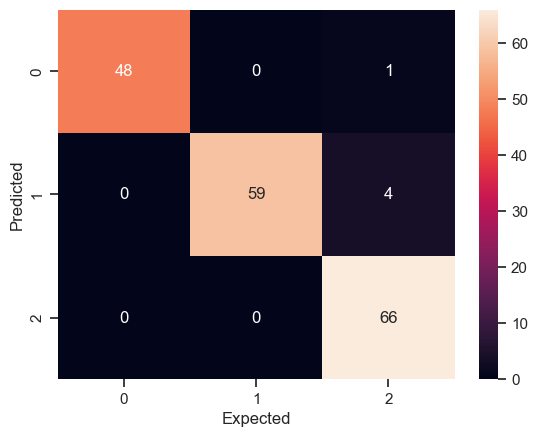

In [13]:
# test evaluation code
indices = np.random.permutation(np.arange(0,len(X),1))

predictions = [mykNN(X,y,X[i],3,'manhattan') for i in indices]
original = [y[i] for i in indices]

matrix = myConfusionMatrix(predictions,original)
myClassifierEvaluation(matrix, ["precision", "recall", "specificity", "sensitivity", "f1", "accuracy", "heatmap"])


## 4. Nested Cross-validation using your implementation of KNN  [6 pts]

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes. 

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [14]:
# parameters for testing code
nFolds = 5
np.random.seed(mySeed)

# Creates an array of random permutation of indices between 0 and the length of the X data.
# The indices are then split up into (folds) folds
indices = np.random.permutation(np.arange(0,len(X),1))
indices = np.array_split(indices, nFolds)

In [15]:
def avg(values):
    """
    Calculate the average of a list of values.

    Args:
        values (list): A list of numerical values.

    Returns:
        float: The average value.

    """
    if not values:
        return 0
    
    total_sum = 0
    count = 0
    
    for value in values:
        total_sum += value
        count += 1
    
    average = total_sum / count
    return average

def std_dev(values):
    """
    Calculate the standard deviation of a list of values.

    Args:
        values (list): A list of numerical values.

    Returns:
        float: The standard deviation.

    """
    n = len(values)
    if n < 2:
        return 0.0

    mean = sum(values) / n
    squared_diff_sum = sum((x - mean) ** 2 for x in values)
    variance = squared_diff_sum / (n - 1)
    standard_deviation = variance ** 0.5

    return standard_deviation

In [16]:
# myNestedCrossVal code
def myNestedCrossVal(x_values, y_values, folds = 1, k_values = [3], distance_functions = ['euclidean','manhattan'], seed = 12345, print_out = True):
    """
    Perform nested cross-validation for evaluating a kNN classifier's performance with different parameters.

    Args:
        x_values (array-like): Input features.
        y_values (array-like): Target values.
        folds (int, optional): Number of folds for cross-validation. Default is 1.
        k_values (list, optional): List of k values to evaluate. Default is [3].
        distance_functions (list, optional): List of distance functions to evaluate
            Default is: ['euclidean', 'manhattan']
            Available options: ['euclidean', 'cosine', 'manhattan', 'minkowski1', 'minkowski2', 'minkowski3', 'combined']
        seed (int, optional): Seed value for random number generation. Default is 12345.
        print_out (bool, optional): Flag to print the results. Default is True.

    Returns:
        summary_matrix (array-like): Summary confusion matrix combining all folds.

    Prints:
        - Accuracy table for each fold and parameter combination (if print_out is True)
        - Best accuracy for each fold and its corresponding parameters (if print_out is True)
    """

    np.random.seed(seed)
    indices = np.random.permutation(np.arange(0,len(x_values),1))
    indices = np.array_split(indices, folds)
    if print_out:
        format_row = "{:>10}{:>10}{:>20}{:>25}"
        print(format_row.format("Fold", "K", "Function", "Accuracy"))

    best_tuples = []
    fold_matrices = []
    accuracies = []

    for fold in range(0,folds):
        if print_out:
            print("=================================================================")

        remaining_folds = np.delete(range(0,folds), fold)
        remaining_x = []
        remaining_y = []
        fold_matrix = []

        for remaining_fold in remaining_folds:
            for index in indices[remaining_fold]:
                remaining_x += [x_values[index]]
                remaining_y += [y_values[index]]

        fold_tuples = []

        for k in k_values:
            for distance_function in distance_functions:
                predictions = [mykNN(remaining_x, remaining_y, x_values[i], k, distance_function) for i in indices[fold]]
                original = [y[i] for i in indices[fold]]
                matrix = myConfusionMatrix(predictions,original)
                
                if len(fold_matrix) == 0: fold_matrix = matrix
                else: fold_matrix = np.add(fold_matrix, matrix)

                accuracy_set = (fold+1,k,distance_function,myAccuracy(matrix))
                fold_tuples += [accuracy_set]
                accuracies+= [accuracy_set[3]]

                if print_out:
                    print(format_row.format(accuracy_set[0],accuracy_set[1],accuracy_set[2],accuracy_set[3]))

        fold_matrices += [fold_matrix]
        max_acc = max(f[3] for f in fold_tuples)
        best_tuples += [sorted([f for f in fold_tuples if f[3] == max_acc], key= lambda x: x[1])[0]]
    
    summary_matrix = []
    for matrix in fold_matrices:
        if len(summary_matrix) == 0: summary_matrix = matrix
        else: summary_matrix = np.add(summary_matrix, matrix)

    if print_out:
        print()
        print(format_row.format("Fold", "K", "Function", "Accuracy"))
        for tuple in best_tuples:
            print(format_row.format(tuple[0],tuple[1],tuple[2],tuple[3]))
        print()
        print(f'Average Accuracy: {avg(accuracies)} +- {std_dev(accuracies)}')
    
    return summary_matrix

In [17]:
# evaluate clean data code
cross_val_matrix_x = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan','cosine'], mySeed)

      Fold         K            Function                 Accuracy
         1         1           euclidean       0.9722222222222222
         1         1           manhattan       0.9722222222222222
         1         1              cosine       0.8333333333333334
         1         2           euclidean       0.9722222222222222
         1         2           manhattan       0.9722222222222222
         1         2              cosine       0.8611111111111112
         1         3           euclidean       0.9722222222222222
         1         3           manhattan       0.9722222222222222
         1         3              cosine       0.8611111111111112
         1         4           euclidean       0.9722222222222222
         1         4           manhattan       0.9722222222222222
         1         4              cosine       0.8611111111111112
         1         5           euclidean       0.9722222222222222
         1         5           manhattan       0.9722222222222222
         1

         2         5              cosine       0.9166666666666666
         2         6           euclidean       0.9166666666666666
         2         6           manhattan       0.9444444444444444
         2         6              cosine       0.8888888888888888
         2         7           euclidean       0.9444444444444444
         2         7           manhattan       0.9444444444444444
         2         7              cosine       0.8888888888888888
         2         8           euclidean       0.9444444444444444
         2         8           manhattan       0.9166666666666666
         2         8              cosine       0.8888888888888888
         2         9           euclidean       0.9444444444444444
         2         9           manhattan       0.9444444444444444
         2         9              cosine       0.9166666666666666
         2        10           euclidean       0.8888888888888888
         2        10           manhattan       0.9166666666666666
         2

In [18]:
# evaluate noisy  data code
cross_val_matrix_xn = myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean','manhattan','cosine'], mySeed)

      Fold         K            Function                 Accuracy
         1         1           euclidean       0.9166666666666666
         1         1           manhattan       0.9444444444444444
         1         1              cosine       0.8333333333333334
         1         2           euclidean       0.8611111111111112
         1         2           manhattan       0.8611111111111112
         1         2              cosine                     0.75
         1         3           euclidean       0.9722222222222222
         1         3           manhattan       0.9722222222222222
         1         3              cosine       0.8611111111111112
         1         4           euclidean       0.9722222222222222
         1         4           manhattan       0.9722222222222222
         1         4              cosine       0.8055555555555556
         1         5           euclidean       0.9722222222222222
         1         5           manhattan       0.9722222222222222
         1

In [19]:
combined_cross_val_matrix_xn = myNestedCrossVal(XN,y,5,list(range(1,11)),['combined'], mySeed, print_out = False)

## 5. Summary of results [6 pts]

Using your results from above, fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1. | 0.9722  |  1 | euclidean  |
| 2. | 0.9722  |  5 | manhattan  |
| 3. | 0.9444  |  1 | euclidean  |
| 4. | 0.8857  |  1 | euclidean  |
| 5. | 0.9714  |  1 | manhattan  |
| **total** | 0.9126 $\pm$ 0.0457 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1. | 0.9722  |  3 | euclidean  |
| 2. | 0.9166  |  1 | manhattan  |
| 3. | 0.9444  |  3 | manhattan  |
| 4. | 0.9428  |  4 | manhattan  |
| 5. | 0.9714  |  8 | euclidean  |
| **total** | 0.8781 $\pm$ 0.0642 |   |    |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your ```myNestedCrossVal``` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall. 


CLEAN
                    Group                        1                        2                        3
                precision       0.9111226611226612       0.9490886235072281       0.8827397260273973
                   recall       0.9429800968262507       0.8526256352343309       0.9421052631578948
              specificity       0.9480558930741191       0.9764876632801162       0.9384526890997987
              sensitivity       0.9429800968262507       0.8526256352343309       0.9421052631578948
                       f1       0.9267776896642878       0.8982748364069006       0.9114568599717114

           model accuracy       0.9127340823970037


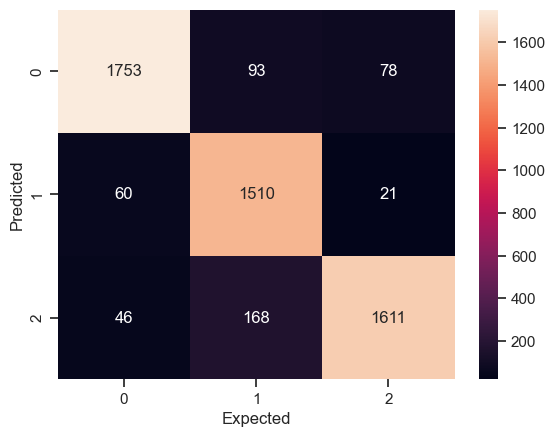

In [20]:
print('CLEAN')
myClassifierEvaluation(cross_val_matrix_x, ["precision", "recall", "specificity", "sensitivity", "f1", "accuracy", "heatmap"])

NOISY
                    Group                        1                        2                        3
                precision       0.8539384454877412       0.8835534213685474       0.8992601024473534
                   recall       0.8906420021762785        0.863849765258216       0.8787541713014461
              specificity       0.9159663865546218       0.9431251832307241       0.9461351186853317
              sensitivity       0.8906420021762785        0.863849765258216       0.8787541713014461
                       f1       0.8719041278295606       0.8735905044510386        0.888888888888889

           model accuracy       0.8780898876404495


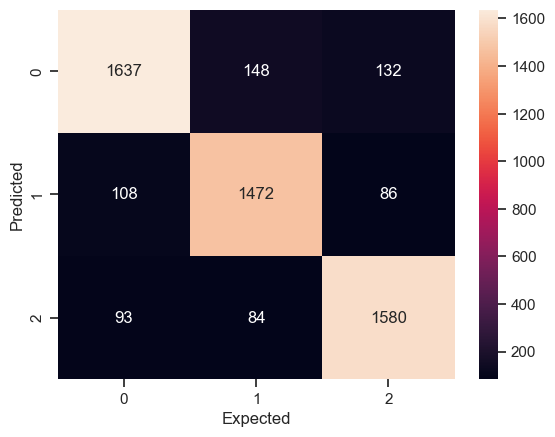

In [21]:
print('NOISY')
myClassifierEvaluation(cross_val_matrix_xn, ["precision", "recall", "specificity", "sensitivity", "f1", "accuracy", "heatmap"])

                    Group                        1                        2                        3
                precision       0.9042207792207793        0.892226148409894       0.9347826086956522
                   recall       0.8983870967741936       0.9148550724637681       0.9194078947368421
              specificity       0.9474621549421193       0.9481733220050977       0.9645776566757494
              sensitivity       0.8983870967741936       0.9148550724637681       0.9194078947368421
                       f1       0.9012944983818771       0.9033989266547405       0.9270315091210614

           model accuracy       0.9106741573033708


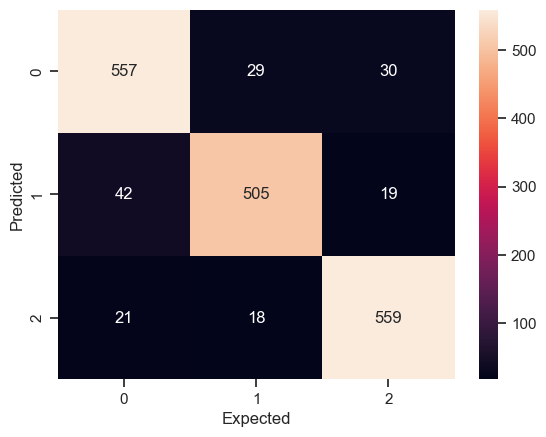

In [22]:
myClassifierEvaluation(myNestedCrossVal(XN,y,5,list(range(1,11)),['combined'], mySeed, print_out = False), ["precision", "recall", "specificity", "sensitivity", "f1", "accuracy", "heatmap"])

## 6. More questions [9 pts]

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in the Markdown cells below each question.



### Q3.	 Influence of noise
Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used? 


Answer:

<pre>
Although the top accuracy of available parameters does seem to increase per fold between data with noise opposed to data without,
the overall accuracy did decrease. We can also evaluate that, in general, a higher k-value is required for noisy data to achieve optimal accuracy.
As for the other parameters, whilst using manhattan and euclidean distance as distance functions, the normal data does seem to favor euclidean and the noisy data favors manhattan.
However, this may very well be something disproven when using more folds or a larger data set.
For the noisy data the KNN algorithm seem to favor higher k-values for optimal accuracy, which would make sense,
since the class clusters are a bit more distributed, this however would also have to be confirmed with more data, higher noise and different fold counts.
</pre>

### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

Answer:

<pre>
if the count of the minimum value in a list of distances > 1
    then
        return the class of the neighbor closest to the mean of all values
        *(return the class of the neighbor occurring the most)
else
    then
        return the class of the minimum value
</pre>

### Q5.	Beyond Wine 
If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code. 


Answer:
<pre>
Overall the code was developed to be compatible with most data sets once they have been cleaned and normalized.
Some changes that would be recommend would be to test and optimize the functions for larger amounts of data,
It would also be recommended to cater for categorical data.

Memory optimization and optimization of the function's utilization cal be beneficial, as at the moment,
for example, the length of the matrix is calculated for each individual function.
The collection of functions could therefor be reworked as a classes to which the matrix or array of are provided once,
and can then be called separately for every required function, which can share shared properties.
</pre>

In [23]:
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean'], mySeed, print_out = False), ["accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['manhattan'], mySeed, print_out = False), ["accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['cosine'], mySeed, print_out = False), ["accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['minkowski1'], mySeed, print_out = False), ["accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['minkowski2'], mySeed, print_out = False), ["accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['minkowski3'], mySeed, print_out = False), ["accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['combined'], mySeed, print_out = False), ["accuracy"])

           model accuracy       0.9280898876404494
           model accuracy       0.9286516853932584
           model accuracy       0.8814606741573033
           model accuracy       0.9303370786516854
           model accuracy       0.9275280898876405
           model accuracy       0.9269662921348315
           model accuracy       0.9269662921348315


In [24]:
myClassifierEvaluation(myNestedCrossVal(XN,y,5,list(range(1,11)),['combined'], mySeed, print_out = False), ["precision", "recall", "specificity", "sensitivity", "f1", "accuracy"])
myClassifierEvaluation(myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean'], mySeed, print_out = False), ["precision", "recall", "specificity", "sensitivity", "f1", "accuracy"])

                    Group                        1                        2                        3
                precision       0.9042207792207793        0.892226148409894       0.9347826086956522
                   recall       0.8983870967741936       0.9148550724637681       0.9194078947368421
              specificity       0.9474621549421193       0.9481733220050977       0.9645776566757494
              sensitivity       0.8983870967741936       0.9148550724637681       0.9194078947368421
                       f1       0.9012944983818771       0.9033989266547405       0.9270315091210614

           model accuracy       0.9106741573033708
                    Group                        1                        2                        3
                precision       0.9221374045801527       0.9654510556621881        0.902317880794702
                   recall       0.9741935483870968       0.8525423728813559        0.956140350877193
              specificity       0.95359

<hr>

In [25]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


<hr>
<u><h2>References</h2></u>

<div class="csl-bib-body" style="line-height: 1.35; ">
  <div class="csl-entry" style="margin-bottom: 1em;"><i>1.6. Nearest Neighbors</i> (no date) <i>scikit-learn</i>. Available at: <a href="https://scikit-learn/stable/modules/neighbors.html">https://scikit-learn/stable/modules/neighbors.html</a> (Accessed: 25 May 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=1.6.%20Nearest%20Neighbors&amp;rft.description=sklearn.neighbors%20provides%20functionality%20for%20unsupervised%20and%20supervised%20neighbors-based%20learning%20methods.%20Unsupervised%20nearest%20neighbors%20is%20the%20foundation%20of%20many%20other%20learning%20methods%2C%20notably%20m...&amp;rft.identifier=https%3A%2F%2Fscikit-learn%2Fstable%2Fmodules%2Fneighbors.html&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Burkov, A. (2019) <i>The Hundred-Page Machine Learning Book (pg. 41-42)</i>. Draft.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=book&amp;rft.btitle=The%20Hundred-Page%20Machine%20Learning%20Book%20-%20Draft&amp;rft.edition=Draft&amp;rft.aufirst=Andry&amp;rft.aulast=Burkov&amp;rft.au=Andry%20Burkov&amp;rft.tpages=41-42"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Lekhtman, A. (2021) <i>Should I Look at Precision &amp; Recall OR Specificity &amp; Sensitivity?</i>, <i>Medium</i>. Available at: <a href="https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1">https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1</a> (Accessed: 25 May 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Should%20I%20Look%20at%20Precision%20%26%20Recall%20OR%20Specificity%20%26%20Sensitivity%3F&amp;rft.description=In%20the%20data%20science%20community%2C%20it%20is%20common%20to%20look%20at%20precision%20and%20recall%20to%20evaluate%20the%20models%20you%20build.%20In%20the%20medical%20world%2C%20it%20is%E2%80%A6&amp;rft.identifier=https%3A%2F%2Ftowardsdatascience.com%2Fshould-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1&amp;rft.aufirst=Alon&amp;rft.aulast=Lekhtman&amp;rft.au=Alon%20Lekhtman&amp;rft.date=2021-01-10&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Manhattan Distance - an overview | ScienceDirect Topics</i> (no date). Available at: <a href="https://www.sciencedirect.com/topics/mathematics/manhattan-distance">https://www.sciencedirect.com/topics/mathematics/manhattan-distance</a> (Accessed: 25 May 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Manhattan%20Distance%20-%20an%20overview%20%7C%20ScienceDirect%20Topics&amp;rft.identifier=https%3A%2F%2Fwww.sciencedirect.com%2Ftopics%2Fmathematics%2Fmanhattan-distance"></span>
  <div class="csl-entry">Pedamkar, P. (2020) ‘Python Print Table | How can we Print Tables in Python with Examples?’, <i>EDUCBA</i>, 1 March. Available at: <a href="https://www.educba.com/python-print-table/">https://www.educba.com/python-print-table/</a> (Accessed: 25 May 2023).</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=blogPost&amp;rft.title=Python%20Print%20Table%20%7C%20How%20can%20we%20Print%20Tables%20in%20Python%20with%20Examples%3F&amp;rft.description=Guide%20to%20Python%20Print%20Table.%20Here%20we%20discuss%20the%20introduction%20to%20Python%20Print%20Table%2C%20and%20how%20to%20print%20tables%20with%20different%20examples.&amp;rft.identifier=https%3A%2F%2Fwww.educba.com%2Fpython-print-table%2F&amp;rft.aufirst=Priya&amp;rft.aulast=Pedamkar&amp;rft.au=Priya%20Pedamkar&amp;rft.date=2020-03-01&amp;rft.language=en-US"></span>
</div>